# Mode Solver

## Theory

The total potential energy $U$ is
$$
U(x,y,z) = \sum_{n=1}^N q  V_\text{dc}(z_n) + \sum_{n>m}^{N} \frac{q^2}{4 \pi \epsilon_{0}} \frac{1}{\left|z_{n}-z_{m}\right|}
$$
where $z_n$ is the position of n-th ion. And we stipulate that if $i<j$, $z_i<z_j$.

Introducing a dimensionless parameter $\zeta = z/B$. The potental energy on the $z$ axis is
$$
U(x,y,z) = \sum_{n=1}^N q  V_\text{dc}(\zeta_n) + \sum_{n, m=1 \atop m \neq n}^{N} \frac{q^2}{8 \pi \epsilon_{0} B} \frac{1}{\left|\zeta_{n}-\zeta_{m}\right|}
$$
To obtain equilibrium position $\zeta_n^0$, one can get $N$ equations
$$
\frac{\partial U}{\partial \zeta_n} = q \frac{\partial V_\text{dc}}{\partial \zeta_n} - \sum_{m=1}^{n-1} \frac{q^2}{4 \pi \epsilon_{0} B} \frac{1}{\left(\zeta_n-\zeta_m\right)^2} + \sum_{m=n+1}^{N} \frac{q^2}{4 \pi \epsilon_{0} B} \frac{1}{\left(\zeta_n-\zeta_m\right)^2} = 0 ,\, (n=1,2,\cdots,N)
$$
just use Newton method to solve it.

The Lagrangian of the system is:
$$
L = T-U = \sum_{n=1}^{N} \frac{1}{2} M \left(\dot{q}_{n}\right)^2-\sum_{n, m=1}^{N} \frac{1}{2} \left[\frac{\partial^{2} U}{\partial z_n \partial z_m}\right]_0 q_n q_m
$$
for the axial modes:
$$
\frac{\partial^{2} U}{\partial z_n \partial z_m} = \frac{1}{B^2} \frac{\partial^{2} U}{\partial \zeta_n \partial \zeta_m} = \frac{1}{B^2}
\begin{cases}
\frac{\partial^2 U}{\partial \zeta_n^2} ,\, &n=m \\
-\frac{2 q^2}{4 \pi \epsilon_{0} B} \frac{1}{\left|\zeta_n - \zeta_m\right|^3} ,\, &n \neq m
\end{cases}
$$
where
$$
\frac{\partial^2 U}{\partial \zeta_n^2} = q \frac{\partial^2 V_\text{dc}}{\partial \zeta_n^2} +
 \sum_{m=1}^{n-1} \frac{2 q^2}{4 \pi \epsilon_{0} B} \frac{1}{\left(\zeta_n-\zeta_m\right)^3} - \sum_{m=n+1}^{N} \frac{2 q^2}{4 \pi \epsilon_{0} B} \frac{1}{\left(\zeta_n-\zeta_m\right)^3} ,\, (n=1,2,\cdots,N)
$$
The modes are square roots of eigenvalues of the matrix divided by $m_{\mathrm{Ca}}$.

## Main Program

In [14]:
from scipy.optimize import fsolve,minimize_scalar
from scipy.interpolate import UnivariateSpline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from globalvar import *
from freqsol import *
from load import *

In [15]:
DCset = {'DC1':10, 'DC2':0.654, 'DC3':10} # set DC voltage here
DataLabel = 'x,y,z,esbeV' # set your data labels here

Load data generated by COMSOL, and compute the electrical potential based on DC voltage settings

In [16]:
[x,y,z,esbeVs] = load(DataLabel)
esbeV = np.zeros_like(z)
for DCi in DCset:
    esbeV = esbeV + esbeVs[DCi]*DCset[DCi]

## Mode Solver

Interpolate and get the potential function $V_\text{spl}(\zeta)$

In [17]:
zeta = z/(B*1e6)
zetagrid = np.linspace(-0.95,0.95,128)
smoothfactor = 1e-6

Vspl = UnivariateSpline(zeta,esbeV,k=5,s=smoothfactor) # spl.get_residual() <= s
dVspl = Vspl.derivative(1)
ddVspl = Vspl.derivative(2)

Define a appropriate initial postion of two ions, then use the solver to find the equilibrium postion and eigenmodes

In [18]:
def TrialEqpos(V0):
    if V0 <= 0.66:
        # Coeff of Quadratic Term is positive or zero
        inipos = [-0.1,0.1]
    else:
        rightpos = 0.3744 - 0.148 * V0**(-1.631)
        leftpos = -rightpos
        inipos = [leftpos,rightpos]
    return inipos

inipos: [-0.1, 0.1]
w0 = 1.042MHz
w1 = 1.343MHz
eqpos: [-0.03505965  0.03211164]
sep = 26.87um


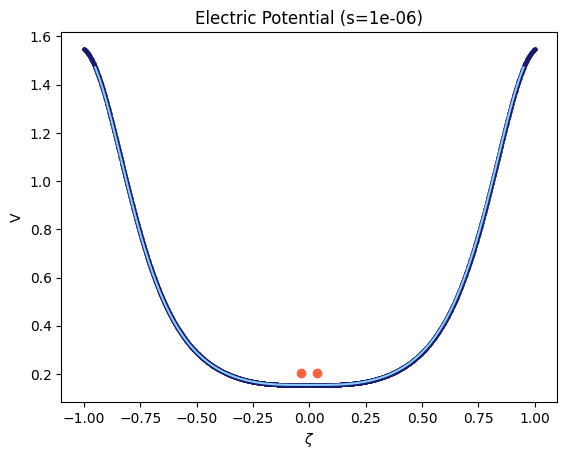

In [19]:
inipos = TrialEqpos(DCset['DC2'])
print('inipos:',inipos)
zeta0 = Eqposition(2,dVspl,ddVspl,inipos)
for i in range(2):
    print('w{0} = {1:.3f}MHz'.format(i,AxialMode(2,ddVspl,zeta0)[i]/1e6))
print('eqpos:',zeta0)
sep = (zeta0[1]-zeta0[0])*400
print('sep = {:.2f}um'.format(sep))

plt.figure()
plt.scatter(zeta,esbeV,s=4,color="midnightblue")
plt.plot(zetagrid,Vspl(zetagrid),color="lightskyblue")
plt.scatter(zeta0,Vspl(zeta0)+0.05,color="tomato")
plt.title('Electric Potential (s={:.0e})'.format(smoothfactor))
plt.xlabel(r'$\zeta$')
plt.ylabel('V')
plt.show()

Find the dependence of eigenmodes and equilibrium position with respect to DC2 when fix DC1 and DC3 to 10V

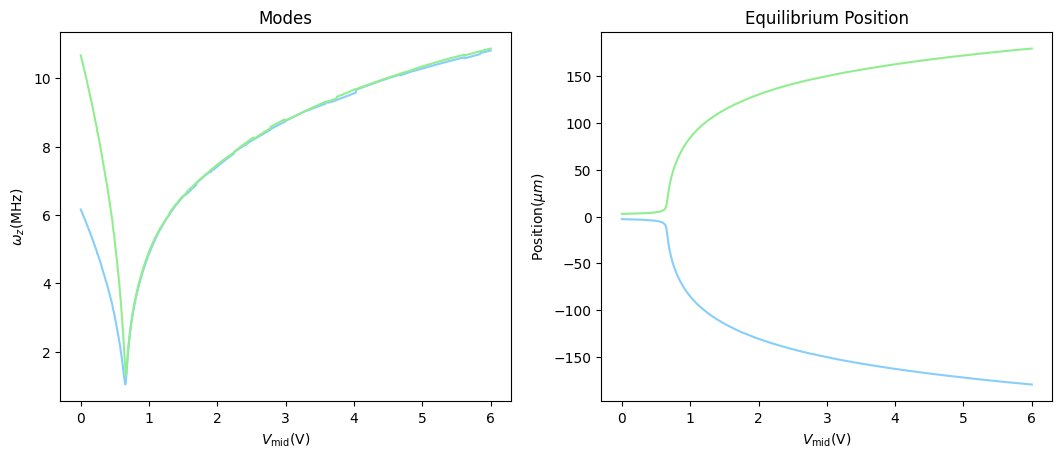

In [20]:
DC2set = np.linspace(0,6,1024)
eqposL = np.empty_like(DC2set)
eqposR = np.empty_like(DC2set)
w0 = np.empty_like(DC2set)
w1 = np.empty_like(DC2set)

for i in range(1024):
    esbeV = np.zeros_like(z)
    DCset['DC2'] = DC2set[i]
    for key in DCset:
        esbeV = esbeV + DCset[key] * esbeVs[key]
    Vspl = UnivariateSpline(zeta,esbeV,k=5,s=smoothfactor)
    dVspl = Vspl.derivative(1)
    ddVspl = Vspl.derivative(2)

    inipos = TrialEqpos(DC2set[i])
    zeta0 = Eqposition(2,dVspl,ddVspl,inipos)
    [eqposL[i],eqposR[i]] = [zeta0[0],zeta0[1]]
    [w0[i],w1[i]] = AxialMode(2,ddVspl,zeta0)/1e6
    
plt.figure(figsize=[12.8,4.8])
plt.subplot(1,2,1)
plt.plot(DC2set,w0,color='lightskyblue', label=r'$\omega_0(ctrlV)$')
plt.plot(DC2set,w1,color='lightgreen', label=r'$\omega_1(ctrlV)$')
plt.title('Modes')
plt.xlabel(r'$V_\mathrm{mid}(\mathrm{V})$')
plt.ylabel(r'$\omega_z(\mathrm{MHz})$')

plt.subplot(1,2,2)
plt.plot(DC2set,eqposL*B*1e6, color='lightskyblue', label='eqposL(ctrlV)')
plt.plot(DC2set,eqposR*B*1e6, color='lightgreen', label='eqposR(ctrlV)')
plt.title('Equilibrium Position')
plt.xlabel(r'$V_\mathrm{mid}(\mathrm{V})$')
plt.ylabel(r'Position($\mu m$)')
plt.show()

## Multi-ions

In [21]:
ionNumber = 4
DCset = {'DC1':10, 'DC2':0.654, 'DC3':10} # set DC voltage here

esbeV = np.zeros_like(z)
for DCi in DCset:
    esbeV = esbeV + esbeVs[DCi]*DCset[DCi]

Define a appropriate initial postion of multi-ions.

In [22]:
def MultiTrialEqpos(ionNumber):
    sep = 0.2
    inipos = np.linspace(-(ionNumber-1)/2*sep,(ionNumber-1)/2*sep,ionNumber)
    return inipos

Evaluate the equilibrium postion and modes

w0 = 1.154MHz
w1 = 1.966MHz
w2 = 2.636MHz
w3 = 2.833MHz
eqpos: [-0.05780633 -0.02145242  0.0183298   0.0543883 ]


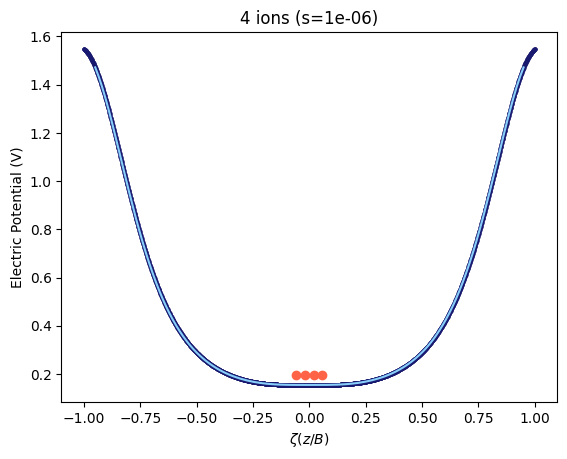

In [23]:
Vspl = UnivariateSpline(zeta,esbeV,k=5,s=smoothfactor) # spl.get_residual() <= s
dVspl = Vspl.derivative(1)
ddVspl = Vspl.derivative(2)

inipos = MultiTrialEqpos(ionNumber)
zeta0 = Eqposition(ionNumber,dVspl,ddVspl,inipos)
for i in range(ionNumber):
    print('w{0} = {1:.3f}MHz'.format(i,AxialMode(ionNumber,ddVspl,zeta0)[i]/1e6))
print('eqpos:',zeta0)

plt.figure()
plt.scatter(zeta,esbeV,s=4,color="midnightblue")
plt.plot(zetagrid,Vspl(zetagrid),color="lightskyblue")
plt.scatter(zeta0,Vspl(zeta0)+0.04,color="tomato")
plt.title('{} ions (s={:.0e})'.format(ionNumber,smoothfactor))
plt.xlabel(r'$\zeta(z/B)$')
plt.ylabel('Electric Potential (V)')
plt.show()

## Superposition

In [24]:
import ipywidgets

In [25]:
def esbeV_plot(DC1=10,DC2=0.6,DC3=10):
    DCset = {'DC1':DC1, 'DC2':DC2, 'DC3':DC3}
    esbeV = np.zeros_like(z)
    for DCi in DCset:
        esbeV = esbeV + esbeVs[DCi]*DCset[DCi]
    plt.subplot(2,2,1)
    plt.plot(z,esbeVs['DC1'],label='DC1')
    plt.legend()
    
    plt.subplot(2,2,2)
    plt.plot(z,esbeVs['DC2'],label='DC2')
    plt.legend()

    plt.subplot(2,2,3)
    plt.plot(z,esbeVs['DC3'],label='DC3')
    plt.legend()
    
    plt.subplot(2,2,4)
    plt.plot(z,esbeV,label='esbeV')
    plt.legend()

In [26]:
ipywidgets.interact(esbeV_plot,DC1=(-10,10,0.1),DC2=(-10,10,0.1),DC3=(-10,10,0.1))

interactive(children=(FloatSlider(value=10.0, description='DC1', max=10.0, min=-10.0), FloatSlider(value=0.6, …

<function __main__.esbeV_plot(DC1=10, DC2=0.6, DC3=10)>